## Collaborative Filtering

In [1]:
import numpy as np 
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import time
sns.set()

In [2]:


### ============ Collaborative Filtering Cost Function ===========
def cofi_cost_func(theta, Y, R, lmda, num_movies, num_features,num_users):
    """ returns the cost and gradient for the collaborative filtering problem. 
    """ 
    #print( lmda,num_movies, num_features,num_users)
    X = theta[:num_movies*num_features].reshape((num_movies, num_features))
    Theta = theta[num_movies*num_features:].reshape((num_users, num_features))
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    
    errors = ( X @ Theta.T - Y ) * R
    regularization_theta = 0.5 * lmda * np.sum(Theta**2)
    regularization_X = 0.5 * lmda * np.sum(X**2)

    J = 0.5 * np.sum(errors**2) + regularization_theta + regularization_X

    # Gradient calculation
    # X_grad - num_movies x num_features matrix, containing the partial derivatives w.r.t. to each element of X
    X_grad[:,:] = errors @ Theta + lmda * X

    #Theta_grad - num_users x num_features matrix, containing the partial derivatives w.r.t. to each element of Theta
    Theta_grad[:,:] = errors.T @ X + lmda * Theta

    return J,X_grad,Theta_grad


def minimize_cost(cost_function,num_users, num_movies,num_features,theta,Y, R,lmda, alpha, num_iters,epsilon=0.0001):
    #Initializing Js
    previousJ=0
    currentJ=0
    history = np.zeros((num_iters,1))

    args = [Y, R, lmda,num_movies, num_features,num_users]
    print('Training collaborative filtering...')
    for i in range(0,num_iters):
        # time.sleep(0.001)  # Adjust speed
        currentJ,grad = cost_function(theta,*args)
        alpha = line_search(cost_function, theta,grad,*args,alpha=alpha)
        history[i,:] = currentJ
        sys.stdout.write(f"\rIteration: {i+1}/{num_iters} Cost:{"{:.2f}".format(currentJ)}  ΔError: {"{:.2f}".format(abs(currentJ-previousJ))}")
        theta[:] = theta - alpha * grad
        # print(e)
        #time.sleep(0.1)
        sys.stdout.flush()
        if(i>0):
            if(abs(currentJ-previousJ)<=epsilon):
                print(f'Max no. of iterations({i}) reached!')
                break
        previousJ = currentJ
    print('\nRecommender system learning completed.')
    return [theta,previousJ,history]\

def line_search(cost_function, theta, d, *args,max_steps=10,alpha=0.001,reduce_by=0.4):
    """
    Performs a simple line search to find the optimal step size.
    
    Parameters:
    cost_function : function
        Function that returns (cost, gradient).
    theta : list
        Current parameters.
    d : list
        Search direction.
    max_steps : int
        Maximum steps for line search.
    
    Returns:
    best_alpha : float
        Optimal step size.
    """
    best_alpha = alpha
    temp = np.zeros_like(theta)

    def get(alpha):
        temp[:] = theta - alpha*d 
        return temp
            
    best_cost, _ = cost_function(get(best_alpha),*args)
    
    for _ in range(max_steps):
        alpha = best_alpha * reduce_by  # Reduce step size
        new_cost, _ = cost_function(get(alpha),*args)
        
        if new_cost < best_cost:
            best_cost = new_cost
            best_alpha = alpha
        else:
            break  # Stop if cost increases
    return best_alpha
def compute_numerical_gradient(J, theta,*args):
    """
    Computes the gradient using "finite differences" and returns a numerical estimate of the gradient
    """
    
    numgrad = np.zeros_like(theta)
    perturb = np.zeros_like(theta)

    n = theta.shape[0]
    e = 1e-4
    for p in range(n):
        # Set perturbation vector
        perturb[p] = e
        loss1 = J(theta - perturb,*args)[0]
        loss2 = J(theta + perturb,*args)[0]
        
        # Compute Numerical Gradient
        numgrad[p] = (loss2 - loss1) / (2*e)
        perturb[p] = 0

    return numgrad

def check_cost_function(lmbda=0):
    """ Checks cost function and gradients"""
    # Create small problem
    X_t = np.random.random((4, 3))
    Theta_t = np.random.random((5, 3))
    
    # Zip out most entries
    Y = X_t @ Theta_t.T
    Y[np.random.random(Y.shape) > 0.5] = 0
    R = np.zeros(Y.shape)
    R[Y != 0] = 1
    
    # Run Gradient Checking
    X = np.random.random((4, 3))
    Theta = np.random.random((5, 3))
    num_users = Y.shape[1]
    num_movies = Y.shape[0]
    num_features = Theta_t.shape[1] 

    theta_i = np.concatenate((X.ravel(),Theta.ravel()))
    numgrad = compute_numerical_gradient(cofi_cost_func, theta_i,*[Y,  R, lmda, num_movies, num_features, num_users])
    [cost, grad] = cofi_cost_func(theta_i,  Y, R, lmbda, num_movies, num_features, num_users)
    
    print([numgrad, grad])
    
    diff = np.linalg.norm(numgrad-grad)/np.linalg.norm(numgrad+grad)
    print('Relative Difference: %g' % diff)

### ===============  Loading movie ratings dataset ================
Load the movie ratings dataset to understand the structure of the data

In [3]:
# Load data
# X - num_movies  x num_features matrix of movie features
# Theta - num_users  x num_features matrix of user features
# Y - num_movies x num_users matrix of user ratings of movies (1682x943)
# R - num_movies x num_users matrix, where R(i, j) = 1 if the i-th movie was rated by the j-th user (1682x943)

data1 = sio.loadmat('../data/movies.mat')
data2 = sio.loadmat('../data/movieParams.mat')

Y,R = data1['Y'],data1['R']
X = data2['X']
Theta = data2['Theta']
num_users = data2['num_users'].item()
num_movies =  data2['num_movies'].item()
num_features =  data2['num_features'].item()

print("No. of users :",num_users)
print("No. of movies :",num_movies)
print("No. of features :",num_features)

print('Average rating for movie 1 (Toy Story): %f' % np.mean(Y[0,R[0,:]==1]))

No. of users : 943
No. of movies : 1682
No. of features : 10
Average rating for movie 1 (Toy Story): 3.878319


Text(0.5, 0, 'Users')

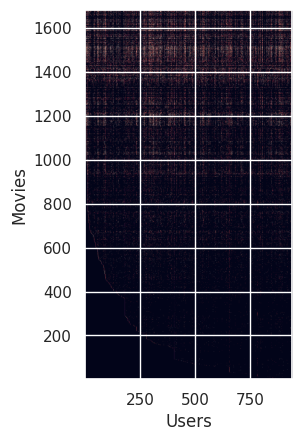

In [4]:
plt.imshow(Y, extent=[1, num_users, 1, num_movies])
plt.ylabel('Movies')
plt.xlabel('Users')

Text(0.5, 0, 'Users')

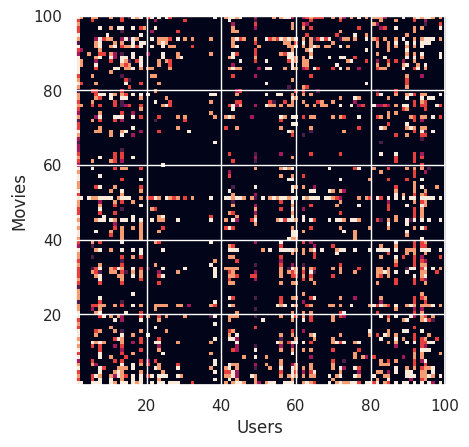

In [5]:
k_movies = 100
k_users = 100

plt.imshow(Y[:k_movies,:k_users], extent=[1, k_users, 1, k_movies])
plt.ylabel('Movies')
plt.xlabel('Users')

In [7]:
X.shape,Theta.shape

((1682, 10), (943, 10))

In [48]:
num_movies, num_users = Y.shape
num_features = X.shape[1]
lmda = 0.01
# Set options for fmincg
max_iter=100

# Set Regularization
lmbda = 10

parameters = np.concatenate((X.flatten(), Theta.flatten()))
J,grad = cofi_cost_func(parameters, Y, R, 1.5,num_movies, num_features,num_users)
J,grad 

(np.float64(34821.70361307223),
 array([-4.68881319,  1.85901252, -5.08442411, ..., -4.63438191,
         3.72934198,  1.85226694], shape=(26250,)))

In [17]:
check_cost_function()

[array([ 0.39552045,  0.45099295,  0.57233029, -0.50843032, -0.99612588,
       -1.0377485 ,  0.00620594,  0.00551331,  0.00405916,  0.9215338 ,
        1.82668399,  1.8625815 ,  0.1554939 ,  0.04916238,  0.09729863,
        0.88409776,  0.88057159,  1.23748174,  0.16666467,  0.05929569,
        0.10540407, -0.47443144, -0.06747071, -0.26267929,  0.58590343,
        0.51053099,  0.75947538]), array([ 0.38901601,  0.44894455,  0.568384  , -0.51291542, -0.99620786,
       -1.04047122,  0.        ,  0.        ,  0.        ,  0.91383991,
        1.82106289,  1.85327265,  0.15000858,  0.04724127,  0.09101126,
        0.88025603,  0.87225331,  1.22767508,  0.15850203,  0.04991606,
        0.0961643 , -0.47544593, -0.06847757, -0.26336981,  0.58204665,
        0.50392548,  0.755047  ])]
Relative Difference: 0.00389776


In [24]:
def load_movie_list(movie_list_file):
    """ 
    Reads the fixed movie list in movie.txt and returns a cell array of the words
    """
    with open(movie_list_file) as f:
        movies_str = f.readlines()

    movies = {}
        
    for line in movies_str:
        idx = line.find(" ")
        movie_id = int(line[:idx])
        movie_name = line[idx+1:].rstrip("\n")
        movies[movie_id] = movie_name
    return movies



def normalize_ratings(Y,R):
    """ Preprocess data by subtracting mean rating for every movie (every row) so that each movie 
    has a rating of 0 on average, and returns the mean rating in Ymean.
    """
    m,n = Y.shape
    Y_mean = np.zeros((m, 1))
    Y_norm = np.zeros((m,n))
    for i in range(m):
        idx = np.where(R[i,:] == 1)
        Y_mean[i] = Y[i, idx].mean()
        Y_norm[i, idx] = (Y[i, idx] - Y_mean[i])
    return Y_mean,Y_norm


In [37]:
movies = load_movie_list('../data/movie_ids.txt')
n = len(movies)
# Entering ratings for a new user
my_ratings = np.zeros((n, 1)) 
my_ratings[7] = 3
my_ratings[12]= 5
my_ratings[54] = 4
my_ratings[64]= 5
my_ratings[66]= 3
my_ratings[69] = 5
my_ratings[183] = 4
my_ratings[226] = 5
my_ratings[355]= 5

In [38]:
### ==================  Learning Movie Ratings ====================
Y_new = np.column_stack((my_ratings,Y))
R_new = np.column_stack(((my_ratings != 0).astype(np.uint8),R))
Y_mean,Y_norm = normalize_ratings(Y_new,R_new)
num_movies,num_users = Y_norm.shape
num_features = 10

print("No. of users :",num_users)
print("No. of movies :",num_movies)
print("No. of features :",num_features)

No. of users : 944
No. of movies : 1682
No. of features : 10


In [39]:
USE_TRAINED = True

if USE_TRAINED:
    initial_parameters = sio.loadmat("../data/weights.mat")['theta'].ravel()
else:
    # Set Initial Parameters (Theta, X)
    X_i = np.random.random((num_movies,num_features))
    Theta_i = np.random.random((num_users,num_features))
    initial_parameters = np.concatenate((X_i.flatten(), Theta_i.flatten()))
# Training hyper paramteters
lmda = 10 # Set Regularization
alpha = 0.001 # Set Learning Rate
num_iters = 100  # Set max no. of iterationas   
initial_parameters.shape

(26260,)

In [40]:
[theta,J,history]  = minimize_cost(cofi_cost_func,num_users, num_movies,num_features,initial_parameters,Y_norm, R_new,lmda, alpha, num_iters)
X_optim = theta[:num_movies*num_features].reshape((num_movies, num_features))
Theta_optim = theta[num_movies*num_features:].reshape((num_users, num_features))

Training collaborative filtering...
Iteration: 100/100 Cost:39034.00  ΔError: 0.1043
Recommender system learning completed.


Text(0.5, 1.0, ' Training cost vs No. iterations')

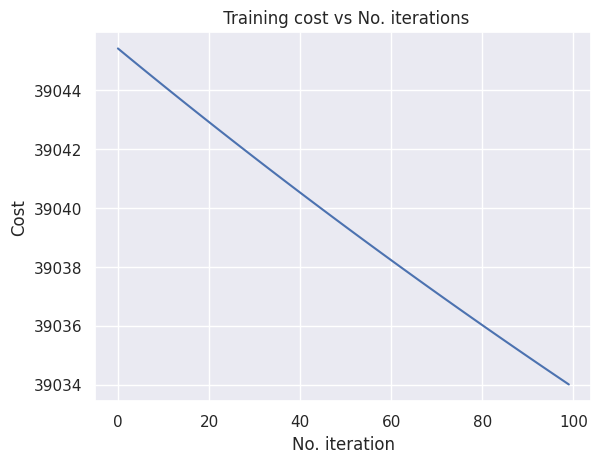

In [41]:
plt.plot(history)
plt.xlabel("No. iteration")
plt.ylabel("Cost")
plt.title(" Training cost vs No. iterations")

In [42]:
# # Predictions
p = X_optim @ Theta_optim.T
predictions_for_me = p[:,0] + Y_mean.ravel()
predicted = np.argsort(predictions_for_me)[::-1]
# predictions_for_me,Y_mean.ravel()

In [43]:
N = 10
print(f'Top {N} recommendations for you:');
for i in range(N):
    print('Predicting rating %.1f for movie %s' % ( predictions_for_me[predicted[i]], movies[predicted[i]+1]))

print('Original ratings provided:')

M = len(my_ratings)
for i in range(M):
    if my_ratings[i] > 0 :
        print('Rated %d for %s' % (my_ratings[i].item(), movies[i+1]))

Top 10 recommendations for you:
Predicting rating 5.0 for movie Great Day in Harlem, A (1994)
Predicting rating 5.0 for movie Santa with Muscles (1996)
Predicting rating 5.0 for movie Saint of Fort Washington, The (1993)
Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996) 
Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.0 for movie Someone Else's America (1995)
Predicting rating 5.0 for movie Aiqing wansui (1994)
Predicting rating 5.0 for movie They Made Me a Criminal (1939)
Predicting rating 5.0 for movie Prefontaine (1997)
Predicting rating 5.0 for movie Star Kid (1997)
Original ratings provided:
Rated 3 for Babe (1995)
Rated 5 for Mighty Aphrodite (1995)
Rated 4 for Professional, The (1994)
Rated 5 for What's Eating Gilbert Grape (1993)
Rated 3 for Ace Ventura: Pet Detective (1994)
Rated 5 for Four Weddings and a Funeral (1994)
Rated 4 for Army of Darkness (1993)
Rated 5 for Star Trek VI: The Undiscovered Co

In [35]:
# Save params
sio.savemat("../data/weights.mat",{"theta": theta})